In [1]:
pip install textblob

In [2]:
pip install scikit-learn

In [3]:
pip install vaderSentiment

In [4]:
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics




In [6]:
data_location = '/content/drive/MyDrive/SentimentAnalysis/ryanNewest.csv'
output_location = '/content/drive/MyDrive/SentimentAnalysis/'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
data = pd.read_csv(data_location)
data['valence'] = (data['valence'] - 3) * (-1)

In [42]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [57]:
import spacy
import pandas as pd
import numpy as np
import json
import time
from collections import Counter
import re

# preprocessing steps (lakshays pipeline)
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself',
             'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
             'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these',
             'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
             'did', 'doing', 'would', 'should', 'could', 'ought', 'i\'m', 'you\'re', 'he\'s', 'she\'s', 'it\'s', 'we\'re', 'they\'re',
             'i\'ve', 'you\'ve', 'we\'ve', 'they\'ve', 'i\'d', 'you\'d', 'he\'d', 'she\'d', 'we\'d', 'they\'d', 'i\'ll', 'you\'ll',
             'he\'ll', 'she\'ll', 'we\'ll', 'they\'ll', 'let\'s', 'that\'s', 'who\'s', 'what\'s', 'here\'s', 'there\'s', 'when\'s',
             'where\'s', 'why\'s', 'how\'s', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
             'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up',
             'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
             'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'will', '\s']

def lemmatizer(memory, model):
    # convert the memory given to tokenized sentence
    sentence = model(memory)

    # extract lemmatized form of all the tokens in the sentence
    # lemmata = [token.lemma_.lower() for token in sentence]
    lemmata = ['sing' if token.text.lower() == 'singing' else token.lemma_.lower()
               for token in sentence]  # tackling edge case since spacy model is lemmatizing 'singing' to 'singe' instead of 'sing'

    # join the lemmatized tokens to get the final lemmatized sentence
    final_sentence = ' '.join(lemmata)

    return final_sentence


def remove_stopwords(memory, stopwords):

    # Tokenize the memory (split into words)
    words = memory.lower().split()

    # Filter out stopwords
    filtered_words = [word for word in words if word not in stopwords]

    # Reconstruct the cleaned text
    cleaned_memory = ' '.join(filtered_words)

    return cleaned_memory


def find_custom_stopwords(memories_list):

    # combine all memories together to get custom stopwords
    memories = ' '.join(memories_list)

    # tokenize the combined memories
    tokens = memories.split()

    # count the frequency of each token and store it
    token_counts = Counter(tokens)
    frequencies = np.array(list(token_counts.values()))
    # print('frequency: ', sorted(frequencies, reverse=True),
    #       len(frequencies), np.sum(frequencies))
    mean_freq = np.mean(frequencies)  # mean of the frequency of tokens
    std_freq = np.std(frequencies)  # SD of the frequency of tokens

    # threshold of computing the custom stopwords is set to MEAN + 4*SD
    threshold = mean_freq + 4 * std_freq

    custom_stopwords = {word for word, count in token_counts.items()
                        if count > threshold}
    # Output results
    print(f"Token Frequencies (only showing Mean + 1 SD = {np.int32(mean_freq+std_freq)} tokens for now):",
          token_counts.most_common(np.int32(mean_freq+std_freq)))
    # print("Token Frequencies:", token_counts)
    print("Mean Frequency:", mean_freq)
    print("Standard Deviation:", std_freq)
    print('Threshold Frequency (Mean + 4 SDs): ', threshold)
    print("Custom Stopwords (4 SDs above mean):", custom_stopwords)

    return custom_stopwords


def remove_puncuation(memory):

    # Regex pattern to match all punctuation marks
    pattern = r"[^\w\s]"

    # Remove all punctuation marks
    memory_no_punctuation = re.sub(pattern, "", memory)

    return memory_no_punctuation


def preprocessing_pipeline(memories_list, stopwords):

    model = spacy.load(f'en_core_web_lg')

    print('\n\t\t >>>>>> STARTING PREPROCESSING STEPS <<<<<<\n\n')
    start = time.time()

    # 1. lemmatizing works good + lowering also done
    print("Step 1:: Starting lemmatization!\n")
    memories_list = [lemmatizer(memory, model) for memory in memories_list]

    # 2. now check for stopwords and remove the one's from snowball stopwords list
    print("Step 2:: Removing snowball stopwords (without negators and including 's token)!\n")
    memories_list = [remove_stopwords(memory, stopwords)
                     for memory in memories_list]

    # 3. remove all the punctuation marks now
    print("Step 3:: Removing punctuation marks!\n")
    memories_list = [remove_puncuation(memory) for memory in memories_list]

    # 4. now check for custom stopwords based on words occuring >3SDs away
    print("Step 4:: Finding custom stopwords!")
    custom_stopwords = find_custom_stopwords(memories_list)

    # 5. remove the custom stopwords now
    print("\nStep 5:: Removing custom stopwords now!\n")
    memories_list = [remove_stopwords(memory, custom_stopwords)
                     for memory in memories_list]

    print('FINAL:: Total time taken for all the preprocessing: ', time.time()-start)

    return memories_list


data["memory_processed"] = preprocessing_pipeline(data["memory"], stopwords)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)



		 >>>>>> STARTING PREPROCESSING STEPS <<<<<<


Step 1:: Starting lemmatization!

Step 2:: Removing snowball stopwords (without negators and including 's token)!

Step 3:: Removing punctuation marks!

Step 4:: Finding custom stopwords!
Token Frequencies (only showing Mean + 1 SD = 44 tokens for now): [('memory', 1005), ('not', 651), ('time', 606), ('friend', 601), ('remember', 554), ('go', 403), ('feel', 393), ('school', 326), ('year', 320), ('think', 314), ('event', 309), ('get', 294), ('family', 255), ('one', 243), ('thing', 238), ('happen', 237), ('come', 235), ('back', 234), ('make', 223), ('day', 218), ('say', 207), ('like', 203), ('just', 190), ('mind', 188), ('something', 187), ('experience', 183), ('pop', 182), ('see', 177), ('first', 177), ('talk', 171), ('play', 161), ('past', 160), ('recollection', 156), ('take', 152), ('boyfriend', 149), ('person', 148), ('good', 141), ('often', 141), ('life', 140), ('moment', 137), ('walk', 134), ('relationship', 130), ('someone', 128), (

In [58]:
sentimentThreshold = 0.01

def polarity_score(score: float, sentiment_threshold: float):
    if score > sentiment_threshold:
        return 1
    elif score < (-1 * sentiment_threshold):
        return -1
    else:
        return 0

def getPS(a, t):
  out = []
  for i in a:
    out.append(polarity_score(i, t))
  return out

lowerThreshold = 0.2
upperThreshold = 0.6

def fiveClass_score(score, lower, upper):
  if score > upper:
    return 2
  elif score > lower:
    return 1
  elif score >= -1*lower:
    return 0
  elif score >= -1*upper:
    return -1
  else:
    return -2

def getFCS(a, l, u):
  out = []
  for i in a:
    out.append(fiveClass_score(i, l, u))
  return out


def toThree(a):
  out = []
  for i in a:
    if i > 1:
      out.append(1)
    elif i < -1:
      out.append(-1)
    else:
      out.append(i)
  return out
analyzer = SentimentIntensityAnalyzer()

tbScores = []
vScores = []
tbScores_noSW = []
vScores_noSW = []
real = data['valence']
words = []

for memIDX in range(data.shape[0]):
  # With SW removed
  curMem = data['memory_processed'][memIDX]
  words.append(len(curMem.split()))
  curBlob = TextBlob(curMem)
  tbScores.append(curBlob.sentiment[0])
  vScores.append(analyzer.polarity_scores(curMem)['compound'])


rsDF = pd.DataFrame({'Real': real,'TextBlob': tbScores, 'VADER': vScores, "WordCount": words})




(array([832., 770., 496., 251.,  74.,  32.,  20.,   3.,   5.,   1.]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <BarContainer object of 10 artists>)

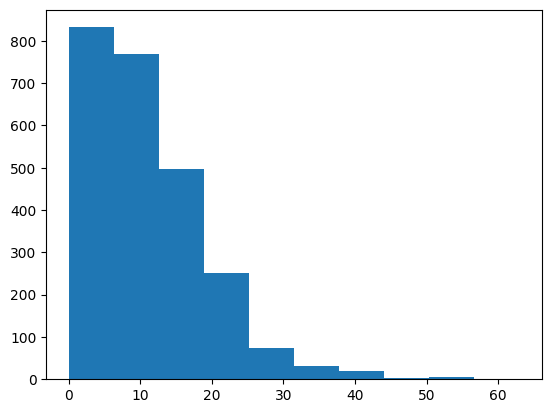

In [12]:
plt.hist(rsDF["WordCount"])

Text(0.5, 1.0, 'Textblob Scores')

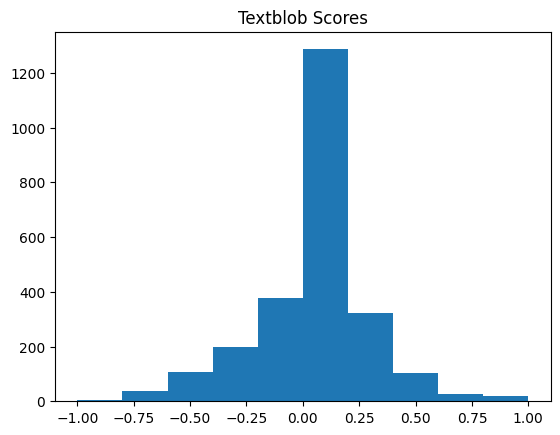

In [ ]:
plt.hist(rsDF['TextBlob'])
plt.title("Textblob Scores")

Text(0.5, 1.0, 'VADER Scores')

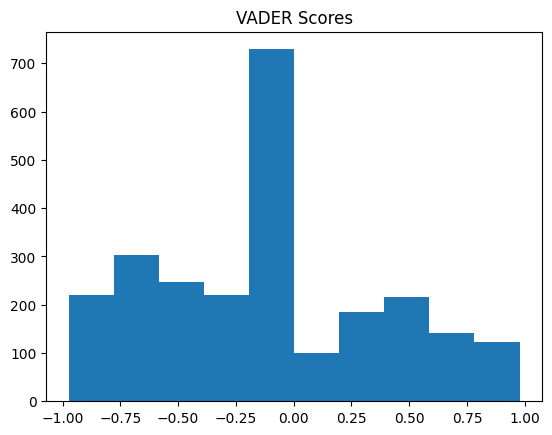

In [ ]:
plt.hist(rsDF['VADER'])
plt.title("VADER Scores")

Text(0, 0.5, 'VADER Scores')

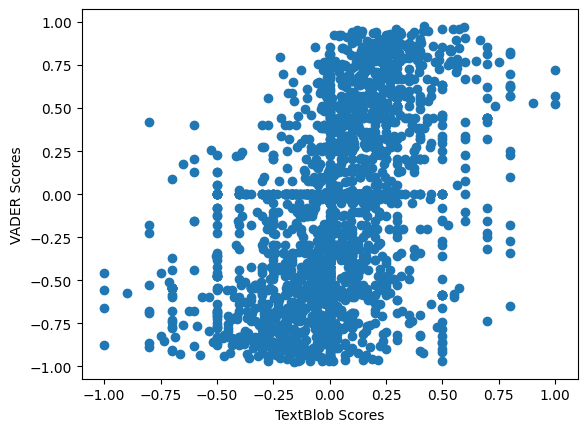

In [ ]:
plt.scatter(rsDF['TextBlob'], rsDF['VADER'])
plt.xlabel('TextBlob Scores')
plt.ylabel('VADER Scores')

<ipython-input-59-323541b5b064>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["", "Negative", "", "Neutral", "", "Positive", ""])


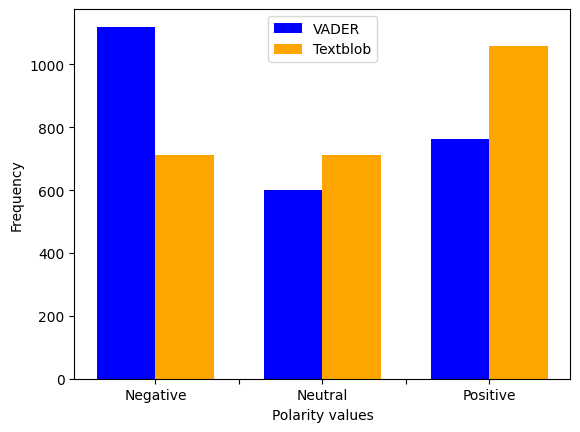

In [59]:
rsDF['TextBlob3'] = getPS(rsDF['TextBlob'], sentimentThreshold)
rsDF['VADER3'] = getPS(rsDF['VADER'], sentimentThreshold)
rsDF['Real3'] = toThree(rsDF['Real'])

bins = np.arange(-1,3)
hist_textblob, _ = np.histogram(rsDF['TextBlob3'], bins=bins)
hist_vader, _ = np.histogram(rsDF['VADER3'], bins=bins)

width = 0.35

# Creating the figure and axes
fig, ax = plt.subplots()

# Plotting the histograms
ax.bar(bins[:-1] - width/2, hist_vader, width=width,
       label='VADER', color='blue')
ax.bar(bins[:-1] + width/2, hist_textblob, width=width,
       label='Textblob', color='orange')

# Adding titles and labels
ax.set_xlabel('Polarity values')
ax.set_xticklabels(["", "Negative", "", "Neutral", "", "Positive", ""])
ax.set_ylabel('Frequency')
ax.legend()

<ipython-input-60-676925ba36f0>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["0%", "10%", "20%", "30%", "40%", "50%"])


(-1.5, 1.5)

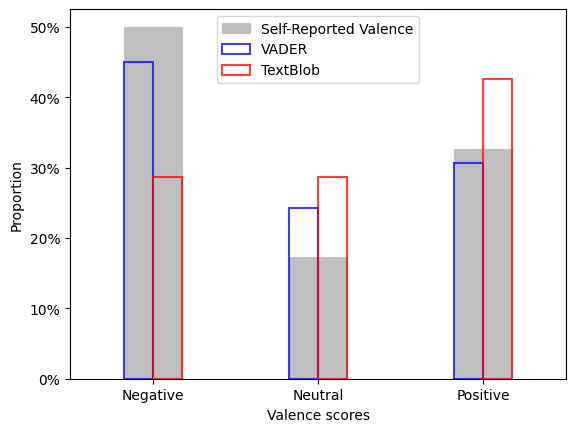

In [60]:
hist_selfvalence, _ = np.histogram(rsDF['Real3'], bins=bins)

hist_vader_prob = hist_vader / sum(hist_vader)
hist_textblob_prob = hist_textblob / sum(hist_textblob)
hist_selfvalence_prob = hist_selfvalence / sum(hist_selfvalence)



# Creating the figure and axes
_, ax = plt.subplots()

# Plotting the histograms
ax.bar(bins[:-1], hist_selfvalence_prob, width=width,
       label='Self-Reported Valence', alpha=0.5, linewidth=1, color='grey', edgecolor='darkgrey')
ax.bar(bins[:-1] - width/4, hist_vader_prob, width=width/2,
       label='VADER', alpha=0.75, linewidth=1.5, fill=False, edgecolor='blue')
ax.bar(bins[:-1] + width/4, hist_textblob_prob, width=width/2,
       label='TextBlob', alpha=0.75, linewidth=1.5, fill=False, edgecolor='red')

# Adding titles and labels
ax.set_xlabel('Valence scores')
ax.set_ylabel('Proportion')

ax.set_xticks(bins[:-1])
ax.set_xticklabels(["Negative", "Neutral", "Positive"])
ax.set_yticklabels(["0%", "10%", "20%", "30%", "40%", "50%"])
ax.legend()
plt.xlim(-1.5, 1.5)


[Text(0, 0, 'Negative'), Text(0, 1, 'Neutral'), Text(0, 2, 'Positive')]

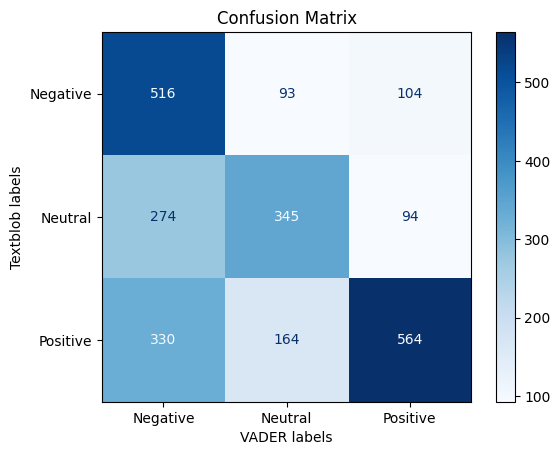

In [61]:
cm = metrics.confusion_matrix(np.array(rsDF['TextBlob3']), np.array(rsDF['VADER3']), labels = [-1, 0, 1])
display = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= [-1, 0, 1])
fig, ax = plt.subplots()
display.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('VADER labels')
ax.set_xticklabels(['Negative','Neutral',"Positive"])
ax.set_ylabel('Textblob labels')
ax.set_yticklabels(['Negative','Neutral',"Positive"])

[Text(0, 0, 'Negative'), Text(0, 1, 'Neutral'), Text(0, 2, 'Positive')]

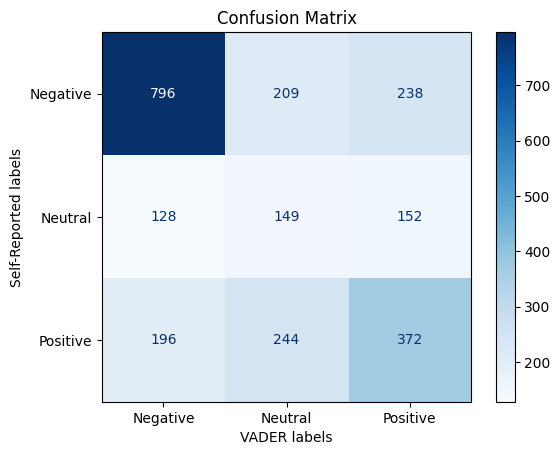

In [62]:
cm = metrics.confusion_matrix(np.array(rsDF['Real3']), np.array(rsDF['VADER3']), labels = [-1, 0, 1])
display = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= [-1, 0, 1])
fig, ax = plt.subplots()
display.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('VADER labels')
ax.set_xticklabels(['Negative','Neutral',"Positive"])
ax.set_ylabel('Self-Reported labels')
ax.set_yticklabels(['Negative','Neutral',"Positive"])

[Text(0, 0, 'Negative'), Text(0, 1, 'Neutral'), Text(0, 2, 'Positive')]

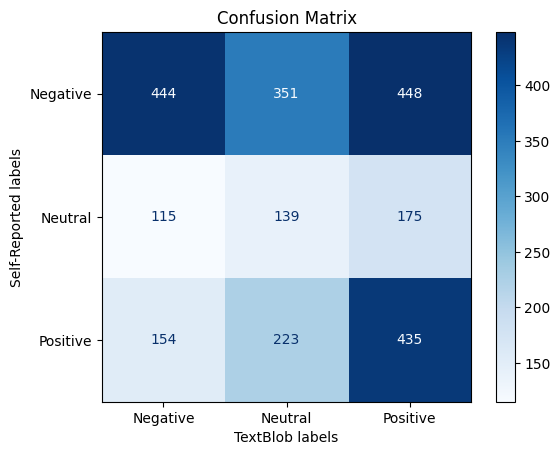

In [63]:
cm = metrics.confusion_matrix(np.array(rsDF['Real3']), np.array(rsDF['TextBlob3']), labels = [-1, 0, 1])
display = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= [-1, 0, 1])
fig, ax = plt.subplots()
display.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('TextBlob labels')
ax.set_xticklabels(['Negative','Neutral',"Positive"])
ax.set_ylabel('Self-Reported labels')
ax.set_yticklabels(['Negative','Neutral',"Positive"])

In [64]:
print('VADER MCC: ', metrics.matthews_corrcoef(rsDF['VADER3'], rsDF['Real3']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(rsDF['TextBlob3'], rsDF['Real3']))

VADER MCC:  0.25857329378268157
TextBlob MCC:  0.1222442405315993


<ipython-input-65-6061fdb84ce1>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["", "Strongly\nNegative", "Negative", "Neutral", "Positive", "Strongly\nPositive",""])


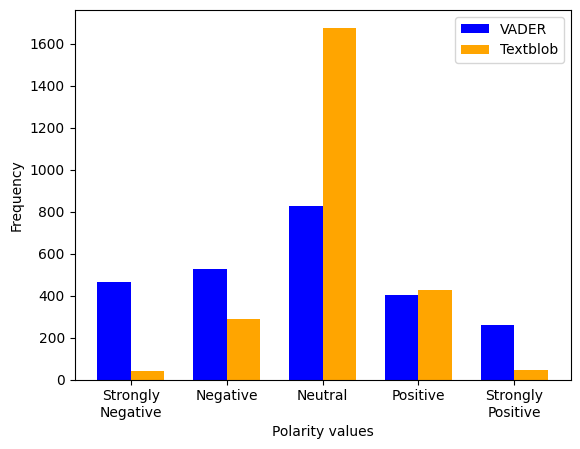

In [65]:
rsDF['TextBlob5'] = getFCS(rsDF['TextBlob'], lowerThreshold, upperThreshold)
rsDF['VADER5'] = getFCS(rsDF['VADER'], lowerThreshold, upperThreshold)

bins = np.arange(-2,4)
hist_textblob, _ = np.histogram(rsDF['TextBlob5'], bins=bins)
hist_vader, _ = np.histogram(rsDF['VADER5'], bins=bins)

width = 0.35

# Creating the figure and axes
fig, ax = plt.subplots()

# Plotting the histograms
ax.bar(bins[:-1] - width/2, hist_vader, width=width,
       label='VADER', color='blue')
ax.bar(bins[:-1] + width/2, hist_textblob, width=width,
       label='Textblob', color='orange')

# Adding titles and labels
ax.set_xlabel('Polarity values')
ax.set_xticklabels(["", "Strongly\nNegative", "Negative", "Neutral", "Positive", "Strongly\nPositive",""])
ax.set_ylabel('Frequency')
ax.legend()

<ipython-input-66-6a04df9a4e5f>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%"])


(-2.5, 2.5)

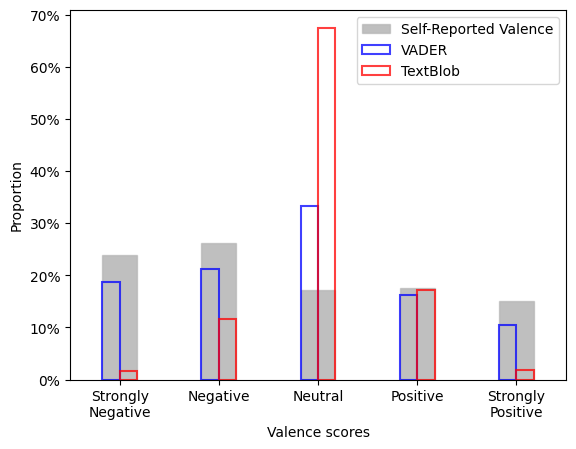

In [66]:
hist_selfvalence, _ = np.histogram(rsDF['Real'], bins=bins)

hist_vader_prob = hist_vader / sum(hist_vader)
hist_textblob_prob = hist_textblob / sum(hist_textblob)
hist_selfvalence_prob = hist_selfvalence / sum(hist_selfvalence)

# Creating the figure and axes
_, ax = plt.subplots()

# Plotting the histograms
ax.bar(bins[:-1], hist_selfvalence_prob, width=width,
       label='Self-Reported Valence', alpha=0.5, linewidth=1, color='grey', edgecolor='darkgrey')
ax.bar(bins[:-1] - width/4, hist_vader_prob, width=width/2,
       label='VADER', alpha=0.75, linewidth=1.5, fill=False, edgecolor='blue')
ax.bar(bins[:-1] + width/4, hist_textblob_prob, width=width/2,
       label='TextBlob', alpha=0.75, linewidth=1.5, fill=False, edgecolor='red')

# Adding titles and labels
ax.set_xlabel('Valence scores')
ax.set_ylabel('Proportion')

ax.set_xticks(bins[:-1])
ax.set_xticklabels(["Strongly\nNegative", "Negative", "Neutral", "Positive", "Strongly\nPositive"])
ax.set_yticklabels(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%"])
ax.legend()
plt.xlim(-2.5, 2.5)

[Text(0, 0, 'Strongly\nNegative'),
 Text(0, 1, 'Negative'),
 Text(0, 2, 'Neutral'),
 Text(0, 3, 'Positive'),
 Text(0, 4, 'Strongly\nPositive')]

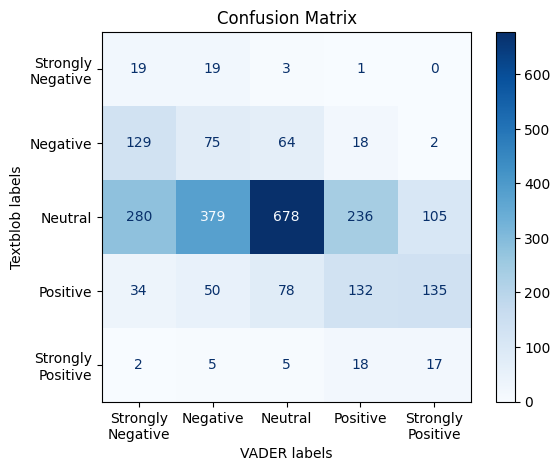

In [67]:
cm = metrics.confusion_matrix(np.array(rsDF['TextBlob5']), np.array(rsDF['VADER5']), labels = [-2, -1, 0, 1, 2])
display = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= [-2, -1, 0, 1, 2])
fig, ax = plt.subplots()
display.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('VADER labels')
ax.set_xticklabels(['Strongly\nNegative','Negative','Neutral',"Positive","Strongly\nPositive"])
ax.set_ylabel('Textblob labels')
ax.set_yticklabels(['Strongly\nNegative','Negative','Neutral',"Positive","Strongly\nPositive"])

[Text(0, 0, 'Strongly\nNegative'),
 Text(0, 1, 'Negative'),
 Text(0, 2, 'Neutral'),
 Text(0, 3, 'Positive'),
 Text(0, 4, 'Strongly\nPositive')]

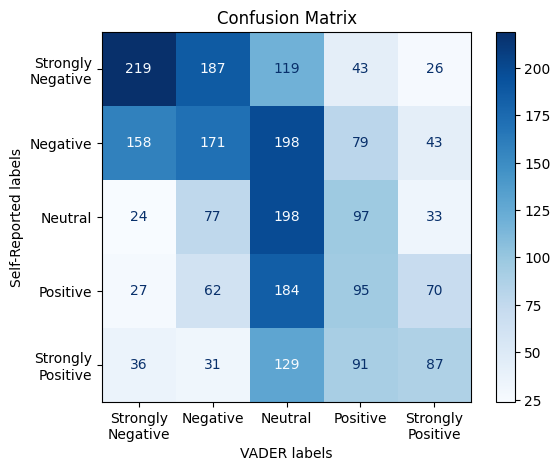

In [68]:
cm = metrics.confusion_matrix(np.array(rsDF['Real']), np.array(rsDF['VADER5']), labels = [-2, -1, 0, 1, 2])
display = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= [-2, -1, 0, 1, 2])
fig, ax = plt.subplots()
display.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('VADER labels')
ax.set_xticklabels(['Strongly\nNegative','Negative','Neutral',"Positive","Strongly\nPositive"])
ax.set_ylabel('Self-Reported labels')
ax.set_yticklabels(['Strongly\nNegative','Negative','Neutral',"Positive","Strongly\nPositive"])

[Text(0, 0, 'Strongly\nNegative'),
 Text(0, 1, 'Negative'),
 Text(0, 2, 'Neutral'),
 Text(0, 3, 'Positive'),
 Text(0, 4, 'Strongly\nPositive')]

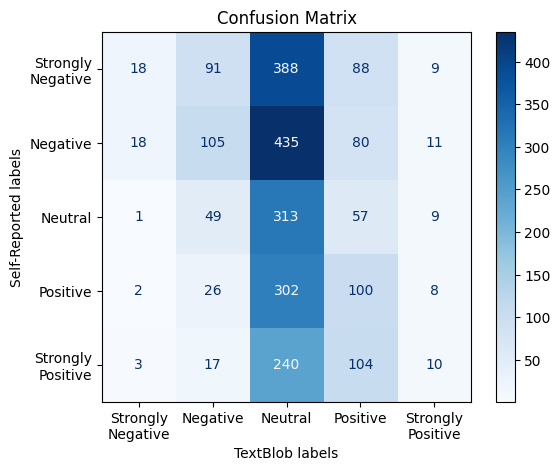

In [69]:
cm = metrics.confusion_matrix(np.array(rsDF['Real']), np.array(rsDF['TextBlob5']), labels = [-2, -1, 0, 1, 2])
display = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= [-2, -1, 0, 1, 2])
fig, ax = plt.subplots()
display.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('TextBlob labels')
ax.set_xticklabels(['Strongly\nNegative','Negative','Neutral',"Positive","Strongly\nPositive"])
ax.set_ylabel('Self-Reported labels')
ax.set_yticklabels(['Strongly\nNegative','Negative','Neutral',"Positive","Strongly\nPositive"])

In [70]:
print('VADER MCC: ', metrics.matthews_corrcoef(rsDF['VADER5'], rsDF['Real']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(rsDF['TextBlob5'], rsDF['Real']))

VADER MCC:  0.13796270221752782
TextBlob MCC:  0.05646856535594787


In [ ]:
upperbound = np.percentile(rsDF["WordCount"], 67)
lowerbound = np.percentile(rsDF['WordCount'], 33)

longmems = rsDF.loc[rsDF["WordCount"] > upperbound,:].reset_index()
midmems = rsDF.loc[(rsDF["WordCount"] >= lowerbound) & (rsDF["WordCount"] <= upperbound),:].reset_index()
shortmems = rsDF.loc[rsDF["WordCount"] < lowerbound,:].reset_index()

In [ ]:
print("Long Memories (>13 Words - top 33%)")
print('-----3Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(longmems['VADER3'], longmems['Real3']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(longmems['TextBlob3'], longmems['Real3']))
print('-----5Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(longmems['VADER5'], longmems['Real']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(longmems['TextBlob5'], longmems['Real']))

Long Memories (>13 Words - top 33%)
-----3Class-----
VADER MCC:  0.39535263442439234
TextBlob MCC:  0.22803040609311606
-----5Class-----
VADER MCC:  0.19268028175701754
TextBlob MCC:  0.0861734648113429


In [ ]:
print("Middle Length Memories (6-13 Words - middle 34%)")
print('-----3Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(midmems['VADER3'], midmems['Real3']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(midmems['TextBlob3'], midmems['Real3']))
print('-----5Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(midmems['VADER5'], midmems['Real']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(midmems['TextBlob5'], midmems['Real']))

Middle Length Memories (7-13 Words - middle 34%)
-----3Class-----
VADER MCC:  0.29312923133736196
TextBlob MCC:  0.1364261770019668
-----5Class-----
VADER MCC:  0.17064649558932335
TextBlob MCC:  0.060222661162813655


In [ ]:
print("Short Memories (<6 Words - bottom 33%)")
print('-----3Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(shortmems['VADER3'], shortmems['Real3']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(shortmems['TextBlob3'], shortmems['Real3']))
print('-----5Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(shortmems['VADER5'], shortmems['Real']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(shortmems['TextBlob5'], shortmems['Real']))

Short Memories (<6 Words - bottom 33%)
-----3Class-----
VADER MCC:  0.2821058156945302
TextBlob MCC:  0.07638626650950016
-----5Class-----
VADER MCC:  0.11472654091022859
TextBlob MCC:  0.0567626806120465


WORD CLOUD STUFF

([], [])

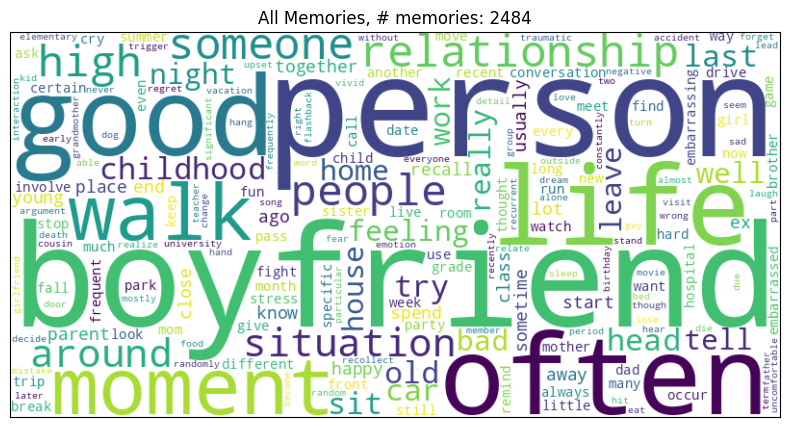

In [ ]:
from wordcloud import WordCloud, STOPWORDS
seed_value = 20867263


memory_texts = data['memory_processed'].dropna().tolist()
cnt = len(memory_texts)

# Combine all texts into a single string if needed
all_memory_texts = ' '.join(memory_texts)

# Create a set of stop words and add custom stop words
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(stopwords)

wordcloud = WordCloud(width=800, height=400,
                      background_color='white', stopwords=custom_stopwords, colormap='viridis', collocations=False, random_state=seed_value).generate(all_memory_texts)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'All Memories, # memories: {cnt}')

# Remove ticks and labels on both axes
plt.xticks([])  # Remove ticks on the x-axis
plt.yticks([])

([], [])

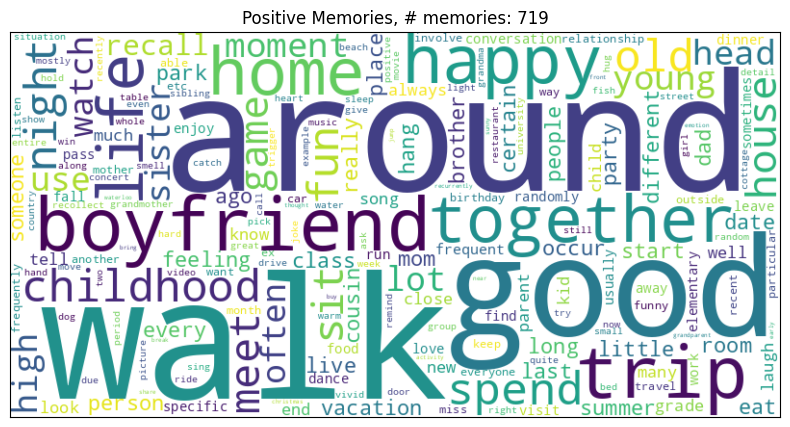

In [ ]:
positive = data.loc[data['valence'] > 0].reset_index(drop=True)
memory_texts = positive['memory_processed'].dropna().tolist()
cnt = len(memory_texts)

# Combine all texts into a single string if needed
all_memory_texts = ' '.join(memory_texts)

# Create a set of stop words and add custom stop words
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(stopwords)

wordcloud = WordCloud(width=800, height=400,
                      background_color='white', stopwords=custom_stopwords, colormap='viridis', collocations=False, random_state=seed_value).generate(all_memory_texts)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Positive Memories, # memories: {cnt}')

# Remove ticks and labels on both axes
plt.xticks([])  # Remove ticks on the x-axis
plt.yticks([])

([], [])

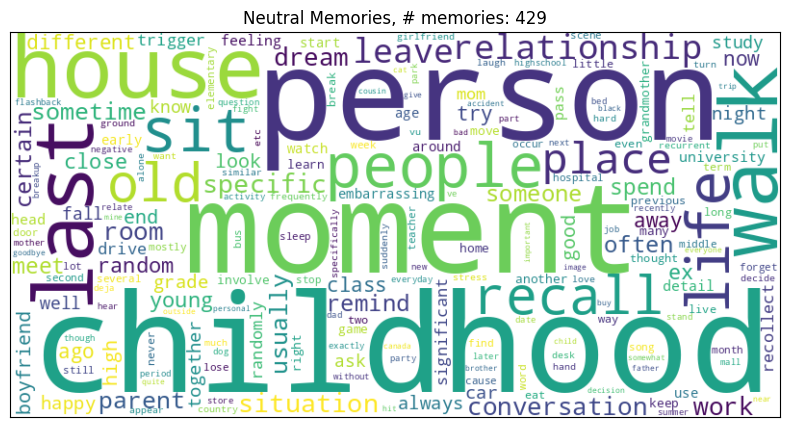

In [ ]:
neutral = data.loc[data['valence'] == 0].reset_index(drop=True)
memory_texts = neutral['memory_processed'].dropna().tolist()
cnt = len(memory_texts)

# Combine all texts into a single string if needed
all_memory_texts = ' '.join(memory_texts)

# Create a set of stop words and add custom stop words
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(stopwords)

wordcloud = WordCloud(width=800, height=400,
                      background_color='white', stopwords=custom_stopwords, colormap='viridis', collocations=False, random_state=seed_value).generate(all_memory_texts)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Neutral Memories, # memories: {cnt}')

# Remove ticks and labels on both axes
plt.xticks([])  # Remove ticks on the x-axis
plt.yticks([])

([], [])

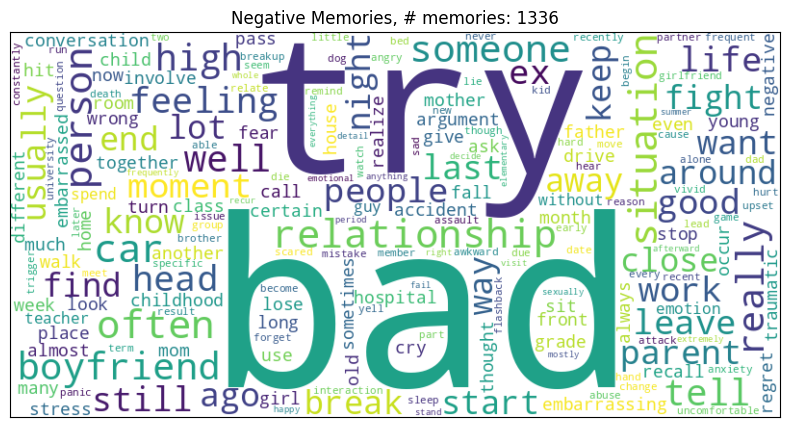

In [ ]:
negative = data.loc[data['valence'] < 0].reset_index(drop=True)
memory_texts = negative['memory_processed'].dropna().tolist()
cnt = len(memory_texts)

# Combine all texts into a single string if needed
all_memory_texts = ' '.join(memory_texts)

# Create a set of stop words and add custom stop words
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(stopwords)

wordcloud = WordCloud(width=800, height=400,
                      background_color='white', stopwords=custom_stopwords, colormap='viridis', collocations=False, random_state=seed_value).generate(all_memory_texts)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Negative Memories, # memories: {cnt}')

# Remove ticks and labels on both axes
plt.xticks([])  # Remove ticks on the x-axis
plt.yticks([])

Word Count Bar Graph (Top 10)

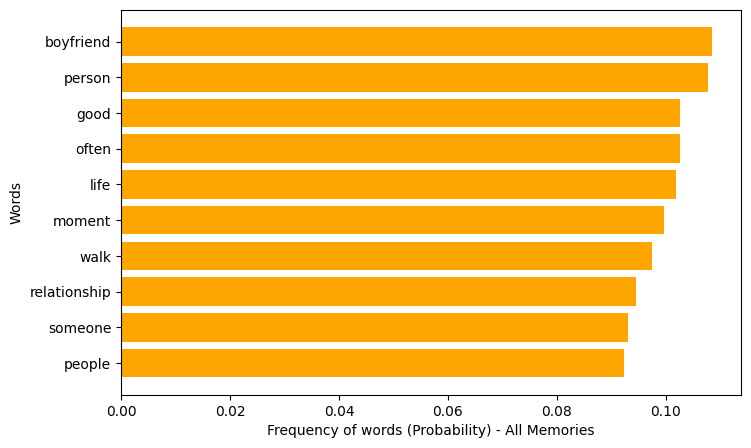

In [ ]:
memory_texts = data['memory_processed'].dropna().tolist()
cnt = len(memory_texts)

# Combine all texts into a single string if needed
all_memory_texts = ' '.join(memory_texts)
raw_word_counts = wordcloud.process_text(all_memory_texts)

# Get the top 10 most popular words by raw count
top_10_words = sorted(raw_word_counts.items(),
                      key=lambda x: x[1], reverse=True)[:10]



# Print the top 10 words with their raw counts
words = []
counts = []
for word, count in top_10_words:
  words.append(word)
  counts.append(count)

plt.figure(figsize=(8, 5))
plt.barh(words, np.array(counts) / sum(counts), color='orange')
plt.ylabel('Words')
plt.xlabel('Frequency of words (Probability) - All Memories')
plt.gca().invert_yaxis()

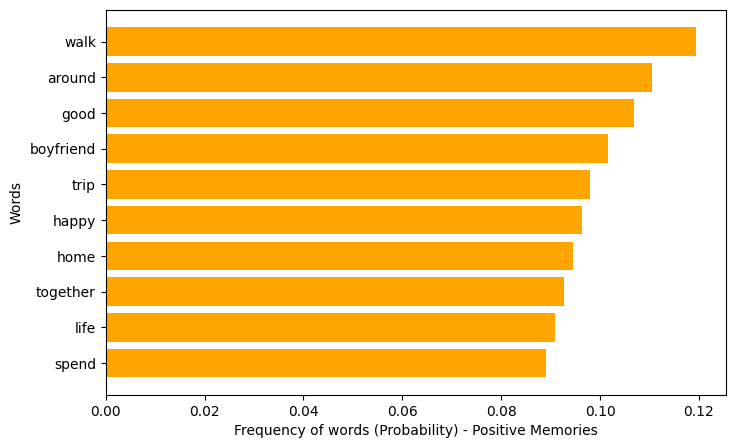

In [ ]:
positive = data.loc[data['valence'] > 0].reset_index(drop=True)
memory_texts = positive['memory_processed'].dropna().tolist()
cnt = len(memory_texts)

# Combine all texts into a single string if needed
all_memory_texts = ' '.join(memory_texts)
raw_word_counts = wordcloud.process_text(all_memory_texts)

# Get the top 10 most popular words by raw count
top_10_words = sorted(raw_word_counts.items(),
                      key=lambda x: x[1], reverse=True)[:10]



# Print the top 10 words with their raw counts
words = []
counts = []
for word, count in top_10_words:
  words.append(word)
  counts.append(count)

plt.figure(figsize=(8, 5))
plt.barh(words, np.array(counts) / sum(counts), color='orange')
plt.ylabel('Words')
plt.xlabel('Frequency of words (Probability) - Positive Memories')
plt.gca().invert_yaxis()

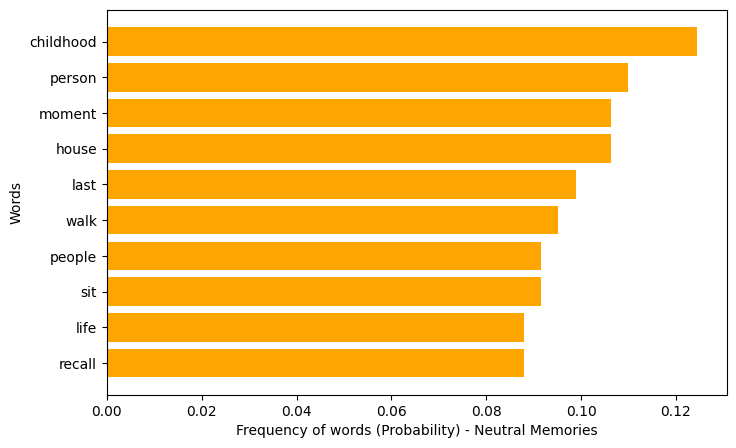

In [ ]:
neutral = data.loc[data['valence'] == 0].reset_index(drop=True)
memory_texts = neutral['memory_processed'].dropna().tolist()
cnt = len(memory_texts)

# Combine all texts into a single string if needed
all_memory_texts = ' '.join(memory_texts)
raw_word_counts = wordcloud.process_text(all_memory_texts)

# Get the top 10 most popular words by raw count
top_10_words = sorted(raw_word_counts.items(),
                      key=lambda x: x[1], reverse=True)[:10]



# Print the top 10 words with their raw counts
words = []
counts = []
for word, count in top_10_words:
  words.append(word)
  counts.append(count)

plt.figure(figsize=(8, 5))
plt.barh(words, np.array(counts) / sum(counts), color='orange')
plt.ylabel('Words')
plt.xlabel('Frequency of words (Probability) - Neutral Memories')
plt.gca().invert_yaxis()

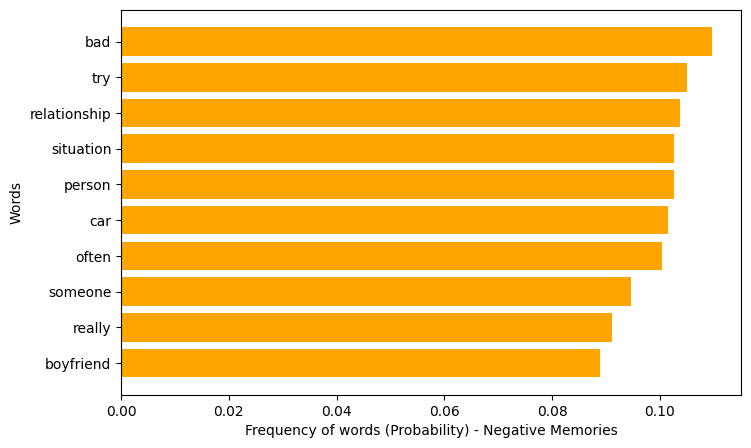

In [ ]:
negative = data.loc[data['valence'] < 0].reset_index(drop=True)
memory_texts = negative['memory_processed'].dropna().tolist()
cnt = len(memory_texts)

# Combine all texts into a single string if needed
all_memory_texts = ' '.join(memory_texts)
raw_word_counts = wordcloud.process_text(all_memory_texts)

# Get the top 10 most popular words by raw count
top_10_words = sorted(raw_word_counts.items(),
                      key=lambda x: x[1], reverse=True)[:10]



# Print the top 10 words with their raw counts
words = []
counts = []
for word, count in top_10_words:
  words.append(word)
  counts.append(count)

plt.figure(figsize=(8, 5))
plt.barh(words, np.array(counts) / sum(counts), color='orange')
plt.ylabel('Words')
plt.xlabel('Frequency of words (Probability) - Negative Memories')
plt.gca().invert_yaxis()

Testing Thresholds

In [ ]:
# Helper functions that we'll use

# Returns a 3 class score
# Is symmetric
def polarity_score(score: float, sentiment_threshold: float):
    if score > sentiment_threshold:
        return 1
    elif score < (-1 * sentiment_threshold):
        return -1
    else:
        return 0

# Wrapper function to apply polarity_score to an array
def getPS(a, t):
  out = []
  for x in a:
    out.append(polarity_score(x, t))
  return out

# Returns a 3 class score, but allows asymmetric thresholds
# n is the negative threshold and p is positive one
def asymmetricPolarity(a, n, p):
  polarities = []
  for x in a:
    if x > p:
      polarities.append(1)
    elif x < n:
      polarities.append(-1)
    else:
      polarities.append(0)
  return polarities

# Returns a 5 class score
# Is symmetric
def fiveClass_score(score, lower, upper):
  if score > upper:
    return 2
  elif score > lower:
    return 1
  elif score > -1*lower:
    return 0
  elif score > -1*upper:
    return -1
  else:
    return -2

# Wrapper function that applies fiveClass_score to an array
def fcScore_list(a, lb, ub):
  out = []
  for x in a:
    out.append(fiveClass_score(x, lb, ub))
  return out

# Essentially polarity score, but with no threshold
def mySign(x):
  if x > 0:
    return 1
  elif x < 0:
    return -1
  else:
    return 0

# Wrapper function for mySign
def getSigns(a):
  out = []
  for i in a:
    out.append(mySign(i))
  return out

In [ ]:
# 3 Class Threshold Analysis function
def threeClassTA(ds):
  tbScores = ds["TextBlob"]
  vScores = ds["VADER"]
  real3 = ds["Real3"]

  positiveThresholds = np.arange(0.00, 1, 0.01)
  negativeThresholds = np.arange(0.00, 1, 0.01) * -1

  tbMCC = []
  vMCC = []
  pT = []
  nT = []
  for p in positiveThresholds:
    for n in negativeThresholds:
      tbScored = asymmetricPolarity(tbScores, n, p)
      vScored = asymmetricPolarity(vScores, n, p)

      pT.append(p)
      nT.append(n)

      tbMCC.append(metrics.matthews_corrcoef(real3, tbScored))
      vMCC.append(metrics.matthews_corrcoef(real3, vScored))

  return pd.DataFrame({'PositiveThresholds': pT, 'NegativeThresholds': nT, 'TextBlobMCC': tbMCC, 'VADERMCC': vMCC})



# 5 Class Threhsold Analysis Function
def fiveClassTA(ds):
  tbScores = ds["TextBlob"]
  vScores = ds["VADER"]
  real5 = ds["Real"]

  lowerbounds = np.arange(0.00, 1, 0.01)

  tbMCC = []
  vMCC = []
  lbT = []
  ubT = []
  for lb in lowerbounds:
    upperbounds = np.arange(lb+0.01, 1, 0.01)
    for ub in upperbounds:
      tbScored = fcScore_list(tbScores, lb, ub)
      vScored = fcScore_list(vScores, lb, ub)

      lbT.append(lb)
      ubT.append(ub)

      tbMCC.append(metrics.matthews_corrcoef(real5, tbScored))
      vMCC.append(metrics.matthews_corrcoef(real5, vScored))

  return pd.DataFrame({'Lowerbounds': lbT, 'Upperbounds': ubT, 'TextBlobMCC': tbMCC, 'VADERMCC': vMCC})

# Makes the MCC heat plots
# ds3 is the 3classTA ds
# ds5 is the 5classTA ds
def heatPlots(ds3, ds5):
  plt.subplot(2,2,1)
  plt.scatter(ds3["PositiveThresholds"], ds3["NegativeThresholds"], c = ds3["VADERMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.title("Vader MCC Scores")
  plt.xlabel("Positive Threshold")
  plt.ylabel("Negative Threshold")

  plt.subplot(2,2,2)
  plt.scatter(ds3["PositiveThresholds"], ds3["NegativeThresholds"], c = ds3["TextBlobMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.title("TextBlob MCC Scores")
  plt.xlabel("Positive Threshold")


  plt.subplot(2,2,3)
  plt.scatter(ds5["Lowerbounds"], ds5["Upperbounds"], c = ds5["VADERMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.xlabel("Lowerbounds")
  plt.ylabel("Upperbounds")

  plt.subplot(2,2,4)
  plt.scatter(ds5["Lowerbounds"], ds5["Upperbounds"], c = ds5["TextBlobMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.xlabel("Lowerbounds")
  plt.subplots_adjust(hspace = .3, wspace = .3)

  plt.show()


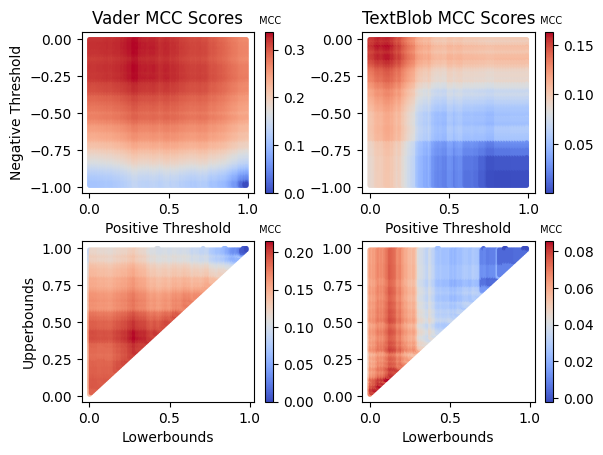

In [ ]:
rsDF['Real3'] = toThree(rsDF['Real'])
out3 = threeClassTA(rsDF)
out5 = fiveClassTA(rsDF)

heatPlots(out3, out5)

In [ ]:
print("Best 3-Class Thresholds - VADER: Positive: ", np.round(out3["PositiveThresholds"][out3["VADERMCC"].argmax()], 2), " Negative: ", np.round(out3["NegativeThresholds"][out3["VADERMCC"].argmax()], 2))
print("Best 3-Class Thresholds - TextBlob: Positive: ", np.round(out3["PositiveThresholds"][out3["TextBlobMCC"].argmax()], 2), " Negative: ", np.round(out3["NegativeThresholds"][out3["TextBlobMCC"].argmax()], 2))
print("Best 5-Class Thresholds - Vader: Lowerbound: ", np.round(out5["Lowerbounds"][out5["VADERMCC"].argmax()], 2), " Upperbound: ", np.round(out5["Upperbounds"][out5["VADERMCC"].argmax()], 2))
print("Best 5-Class Thresholds - TextBlob: Lowerbounds: ", np.round(out5["Lowerbounds"][out5["TextBlobMCC"].argmax()], 2), " Upperbound: ", np.round(out5["Upperbounds"][out5["TextBlobMCC"].argmax()], 2))


Best 3-Class Thresholds - VADER: Positive:  0.28  Negative:  -0.03
Best 3-Class Thresholds - TextBlob: Positive:  0.12  Negative:  -0.05
Best 5-Class Thresholds - Vader: Lowerbound:  0.28  Upperbound:  0.39
Best 5-Class Thresholds - TextBlob: Lowerbounds:  0.1  Upperbound:  0.11


In [ ]:
print("MCC of Best 3-Class Thresholds - VADER: ", out3["VADERMCC"][out3["VADERMCC"].argmax()])
print("MCC of Best 3-Class Thresholds - TextBlob: ", out3["TextBlobMCC"][out3["TextBlobMCC"].argmax()])
print("MCC of Best 5-Class Thresholds - VADER: ", out5["VADERMCC"][out5["VADERMCC"].argmax()])
print("MCC of Best 5-Class Thresholds - TextBlob: ", out5["TextBlobMCC"][out5["TextBlobMCC"].argmax()])

MCC of Best 3-Class Thresholds - VADER:  0.3365266399498466
MCC of Best 3-Class Thresholds - TextBlob:  0.16283870380151802
MCC of Best 5-Class Thresholds - VADER:  0.214836977652906
MCC of Best 5-Class Thresholds - TextBlob:  0.0855680102596916
